# 1. Import Libraries 

In [1]:
import os
import glob
import sys
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
import seaborn as sns
import altair as alt

from skimage import img_as_ubyte, io, color
import cv2

from sklearn.model_selection import train_test_split

#Data balancing SMOTE - imblearn
from imblearn.over_sampling import SMOTE

#PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F

#Skorch
from skorch import NeuralNetClassifier, NeuralNet, NeuralNetRegressor
from skorch.callbacks import EarlyStopping, LRScheduler, EpochScoring,ProgressBar, Checkpoint
from skorch.dataset import CVSplit, ValidSplit
from skorch.callbacks import TrainEndCheckpoint

#model performance
from sklearn.metrics import classification_report,confusion_matrix,ConfusionMatrixDisplay,top_k_accuracy_score, balanced_accuracy_score, f1_score, recall_score

#Scaling
from sklearn.preprocessing import StandardScaler, MinMaxScaler

#Distnce Matrix
from scipy.spatial import distance_matrix, distance

#Supress warnings
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore')

from torch.utils.data import Dataset, DataLoader
#from sklearnex import patch_sklearn
#patch_sklearn()


# 2. Import Data

In [2]:
continous_vector_KG03_df = pd.read_csv("C:/Users/Abhimanyu Acharya/Documents/GitHub/Dissertation/KG_03_continous_attributes.csv")
continous_vector_KG03_df.drop(['Unnamed: 0'],axis=1, inplace = True)
continous_vector_KG03_df.rename(columns={"index": "class"}, inplace = True)
continous_vector_KG03 = continous_vector_KG03_df.iloc[:,1:681].astype(np.float32).values
continous_vector_KG03_df.head()


,class,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511,512,513,514,515,516,517,518,519,520,521,522,523,524,525,526,527,528,529,530,531,532,533,534,535,536,537,538,539,540,541,542,543,544,545,546,547,548,549,550,551,552,553,554,555,556,557,558,559,560,561,562,563,564,565,566,567,568,569,570,571,572,573,574,575,576,577,578,579,580,581,582,583,584,585,586,587,588,589,590,591,592,593,594,595,596,597,598,599,600,601,602,603,604,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624,625,626,627,628,629,630,631,632,633,634,635,636,637,638,639,640,641,642,643,644,645,646,647,648,649,650,651,652,653,654,655,656,657,658,659,660,661,662,663,664,665,666,667,668,669,670,671,672,673,674,675,676,677,678,679
0,antelope,-0.057521,0.019295,0.057478,0.075090,-0.060267,0.054656,-0.065665,-0.014084,0.010333,-0.012144,0.016634,0.050162,0.063289,0.013398,0.002399,0.000702,0.071843,-0.077389,0.036789,-0.109261,-0.048795,-0.055038,-0.135952,0.063456,0.038741,-0.014894,-0.099385,0.064735,0.000454,-0.047995,-0.034473,0.048487,0.000510,0.011095,-0.002778,0.014009,0.045153,-0.011195,-0.016273,-0.066665,0.007961,0.005860,0.061443,0.025402,-0.009059,0.016916,-0.026474,0.020995,0.031061,-0.021807,-0.039752,0.036376,-0.027030,0.054797,-0.026098,-0.001598,0.053415,0.046725,0.056424,0.040684,0.016121,0.108575,0.061185,0.009994,-0.012191,-0.062520,0.035819,0.050966,-0.019316,-0.032111,0.038951,-0.058050,0.044814,-0.031450,0.023064,-0.071938,0.000503,-0.021942,0.017967,0.022314,-0.005883,-0.037258,0.028042,0.037230,0.018083,0.052307,-0.009436,-0.031784,0.016049,0.028512,0.038063,0.037026,0.017714,0.026762,0.054723,0.002871,-0.027428,-0.044480,-0.063178,-0.010574,-0.040556,0.037810,-0.043764,-0.005241,0.050481,0.005309,0.045161,0.013667,0.025585,-0.026841,0.034200,-0.011318,0.009263,-0.043062,-0.026084,0.001287,0.038992,0.012680,0.047751,0.001100,-0.003046,0.054559,-0.016265,-0.002431,-0.022233,0.089014,0.025480,0.009061,0.061804,0.028719,0.002606,-0.007032,0.011892,0.008548,0.093732,0.013703,0.034214,0.042455,0.022524,-0.008608,-0.046437,0.008854,0.004504,0.012037,-0.009223,0.027675,-0

In [3]:
vector = continous_vector_KG03_df.iloc[:,1:]
classes = continous_vector_KG03_df['class']

In [4]:
from scipy.spatial import distance_matrix
original_dist_df = pd.DataFrame(distance_matrix(vector, vector), index=classes, columns=classes)

In [5]:
original_dist_df.head()

class,antelope,grizzly+bear,killer+whale,beaver,dalmatian,persian+cat,horse,german+shepherd,blue+whale,siamese+cat,skunk,mole,tiger,hippopotamus,leopard,moose,spider+monkey,humpback+whale,elephant,gorilla,ox,fox,sheep,seal,chimpanzee,hamster,squirrel,rhinoceros,rabbit,bat,giraffe,wolf,chihuahua,rat,weasel,otter,buffalo,zebra,giant+panda,deer,bobcat,pig,lion,mouse,polar+bear,collie,walrus,raccoon,cow,dolphin
class,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
antelope,0.000000,1.147528,1.141914,1.146415,1.039963,1.208568,0.977083,1.127981,1.137319,1.155790,1.153124,1.102806,1.230917,1.117803,1.080230,0.922558,1.066576,1.108732,1.142278,1.132944,1.019078,1.117781,0.952389,1.189250,1.003156,1.180824,1.119588,1.135512,1.129563,1.178584,0.969271,1.068385,1.241744,1.255060,1.136387,1.211185,0.913525,0.839727,1.257295,0.809335,1.112410,1.111756,1.163785,1.086240,1.112160,1.065203,1.292190,1.172187,0.922081,0.998929
grizzly+bear,1.147528,0.000000,1.167177,1.046892,1.140475,1.149733,1.229409,1.060981,1.131623,1.060303,1.056876,1.094491,1.126553,1.116233,1.017886,1.045536,1.172857,1.107136,1.153047,1.043435,1.149133,1.025328,1.146693,1.128486,1.101898,1.178409,1.172709,1.159400,1.262560,1.037467,1.211722,0.926611,1.096572,1.174251,1.012798,1.112129,0.937919,1.161562,1.015148,1.146581,0.966408,1.147468,1.066746,1.249908,0.879458,1.079488,1.087943,1.058045,1.100203,1.272099
killer+whale,1.141914,1.167177,0.000000,1.149448,1.062701,1.196579,1.173160,1.133202,0.957159,1.181013,1.274128,1.274432,1.119043,1.165789,1.085567,1.268331,1.242308,0.923274,1.221796,1.089919,1.238163,1.175851,1.244566,1.015756,1.200057,1.225119,1.315199,1.197528,1.219601,1.209972,1.185333,1.111113,1.206734,1.113922,1.242319,1.060848,1.166588,1.107465,1.270058,1.184283,1.163009,1.090520,1.116363,1.282394,1.064408,1.101982,1.085001,1.170267,1.094890,0.935488
beaver,1.146415,1.046892,1.149448,0.000000,1.127283,1.099563,1.107471,1.183456,1.078827,1.125312,1.145538,1.113997,1.142565,1.079580,1.162234,1.158900,1.085125,1.099932,1.168865,1.124049,1.208229,1.043950,1.303976,1.171475,1.184406,0.978777,0.968421,1.229847,1.105509,1.200156,1.272872,1.169764,1.170023,1.082791,1.155806,1.023557,1.165400,1.163081,1.207942,1.125886,1.142310,1.234131,1.185985,1.027943,1.115171,1.152782,1.033005,1.165114,1.184631,1.036599
dalmatian,1.039963,1.140475,1.062701,1.127283,0.000000,1.007967,1.008001,0.867368,1.113879,0.977357,1.143591,1.218522,1.028588,1.078139,0.970815,1.170247,1.051005,1.158083,1.159613,1.076105,1.110942,1.091258,1.146554,1.075448,1.092776,1.174234,1.224001,1.217025,1.182537,1.197537,1.080916,0.960258,0.878326,1.237445,1.095505,1.127022,1.147603,1.014790,1.073518,1.053348,1.085568,1.082753,1.162296,1.167222,1.154061,0.795877,1.152155,1.048416,1.022452,0.968809


In [6]:
np.mean(original_dist_df)

class
antelope           1.078102
grizzly+bear       1.082666
killer+whale       1.132435
beaver             1.111100
dalmatian          1.064407
persian+cat        1.093232
horse              1.055330
german+shepherd    1.054343
blue+whale         1.101155
siamese+cat        1.073542
skunk              1.101839
mole               1.099950
tiger              1.091295
hippopotamus       1.113791
leopard            1.078308
moose              1.083053
spider+monkey      1.094911
humpback+whale     1.099239
elephant           1.105771
gorilla            1.091153
ox                 1.075108
fox                1.091502
sheep              1.098825
seal               1.112653
chimpanzee         1.103314
hamster            1.092335
squirrel           1.101635
rhinoceros         1.118433
rabbit             1.094234
bat                1.134430
giraffe            1.099916
wolf               1.065581
chihuahua          1.068354
rat                1.117557
weasel             1.075924
otter         

# 3. Set up Autoencoder Architecture

### 3.1 Straight-Through Estimator Architecture

In [7]:
#https://discuss.pytorch.org/t/binary-activation-function-with-pytorch/56674/4
#https://hassanaskary.com/python/pytorch/deep%20learning/2020/09/19/intuitive-explanation-of-straight-through-estimators.html#:~:text=A%20straight-through%20estimator%20is,function%20was%20an%20identity%20function.
class STEFunction(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input):
        return (input > 0).float()

    @staticmethod
    def backward(ctx, grad_output):
        return F.hardtanh(grad_output)

class StraightThroughEstimator(nn.Module):
    def __init__(self):
        super(StraightThroughEstimator, self).__init__()

    def forward(self, x):
        x = STEFunction.apply(x)
        return x

### 3.1 Define DNN for projection network

In [74]:
class Encoder(nn.Module):
    def __init__(self, num_units):
        super().__init__()
        self.num_units = num_units
        
        self.encode = nn.Sequential(
            nn.Linear(680, 680),
            nn.ReLU(),
            nn.Linear(680, self.num_units),
            nn.ReLU(),
            StraightThroughEstimator(), 
        )
        
    def forward(self, X):
        encoded = self.encode(X)
        return encoded

In [75]:
class Decoder(nn.Module):
    def __init__(self, num_units):
        super().__init__()
        self.num_units = num_units
        
        self.decode = nn.Sequential(
            nn.Linear(self.num_units, 680),
            nn.ReLU(),
            nn.Linear(680, 680),
            nn.Tanh(),
            )
        
    def forward(self, X):
        decoded = self.decode(X)
        return decoded

In [76]:
#https://colab.research.google.com/github/skorch-dev/skorch/blob/master/notebooks/Advanced_Usage.ipynb#scrollTo=SmMcdzsvf6P3
class AutoEncoder(nn.Module):
    def __init__(self, num_units):
        super().__init__()
        self.num_units = num_units

        self.encoder = Encoder(num_units=self.num_units)
        self.decoder = Decoder(num_units=self.num_units)
        
    def forward(self, X):
        encoded = self.encoder(X)
        decoded = self.decoder(encoded)
        return decoded, encoded  # <- return a tuple of two values

In [77]:
class AutoEncoderNet(NeuralNetRegressor):
    def get_loss(self, y_pred, y_true, *args, **kwargs):
        decoded, encoded = y_pred  # <- unpack the tuple that was returned by `forward`
        loss_reconstruction = super().get_loss(decoded, y_true, *args, **kwargs)
        loss_l1 = 1e-3 * torch.abs(encoded).sum()
        return loss_reconstruction + loss_l1

In [78]:
# Create Checkpoint
CP1 = Checkpoint(monitor='valid_loss_best',dirname='exp1')
ES = EarlyStopping(monitor='valid_loss', patience=10, threshold=0.0001, threshold_mode='rel', lower_is_better=True)

In [79]:
LR = LRScheduler(policy='WarmRestartLR')
#LR = LRScheduler(policy='CosineAnnealingLR', T_max=5, eta_min=1)
#LR = LRScheduler(policy='StepLR', step_size=10, gamma=.1)
#LR = LRScheduler(policy='ReduceLROnPlateau', mode='max', factor=0.1, patience=1, verbose=True)
#LR = LRScheduler(policy='TorchCyclicLR', base_lr=0.08, max_lr=.1, mode = 'triangular2',step_size_up=5, step_size_down=3,)
#LR = LRScheduler(policy='TorchCyclicLR', base_lr=0.1, max_lr=.5, mode = 'triangular2',step_size_up=2, step_size_down=4,)
#LR = LRScheduler(policy='TorchCyclicLR', base_lr=.0001, max_lr=.1, mode = 'triangular2',step_size_up=5, step_size_down=3,)


In [92]:
torch.manual_seed(0)

net01 = AutoEncoderNet(
AutoEncoder,
module__num_units=680,
#module__dropout = 0.2,
#iterator_train__shuffle=True, 
#iterator_valid__shuffle=True, 
batch_size= 5,
max_epochs= 5,
lr=.0001,
criterion = nn.MSELoss(), 
optimizer=torch.optim.Adam,
optimizer__weight_decay = 1e-3,
callbacks=[CP1],
train_split = ValidSplit(5),
device='cuda'
)

In [93]:
X = continous_vector_KG03
y = continous_vector_KG03
net01.fit(X,y)

  epoch    train_loss    valid_loss    cp     dur
-------  ------------  ------------  ----  ------
      1        1.5579        1.3506     +  0.1464
      2        1.1234        0.9030     +  0.0654
      3        0.6758        0.4540     +  0.0388
      4        0.2826        0.1613     +  0.0206
      5        0.0804        0.0469     +  0.0245


<class '__main__.AutoEncoderNet'>[initialized](
  module_=AutoEncoder(
    (encoder): Encoder(
      (encode): Sequential(
        (0): Linear(in_features=680, out_features=680, bias=True)
        (1): ReLU()
        (2): Linear(in_features=680, out_features=680, bias=True)
        (3): ReLU()
        (4): StraightThroughEstimator()
      )
    )
    (decoder): Decoder(
      (decode): Sequential(
        (0): Linear(in_features=680, out_features=680, bias=True)
        (1): ReLU()
        (2): Linear(in_features=680, out_features=680, bias=True)
        (3): Tanh()
      )
    )
  ),
)

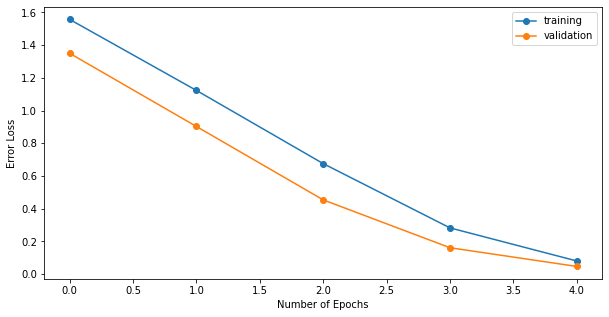

In [94]:
train_loss = net01.history[:, 'train_loss']
valid_loss = net01.history[:, 'valid_loss']
plt.figure(figsize=(10,5))
plt.plot(train_loss, 'o-', label='training')
plt.plot(valid_loss, 'o-', label='validation')
plt.xlabel('Number of Epochs', fontsize=10)
plt.ylabel('Error Loss', fontsize=10)
plt.legend()
plt.show() 

In [95]:
net01.load_params(checkpoint=CP1)

In [96]:
decoded_pred, encoded_pred = net01.forward(X)
decoded_pred.shape, encoded_pred.shape

(torch.Size([50, 680]), torch.Size([50, 680]))

In [97]:
recon_vector_df = pd.DataFrame(decoded_pred.detach().numpy(), index=classes)
recon_vector_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511,512,513,514,515,516,517,518,519,520,521,522,523,524,525,526,527,528,529,530,531,532,533,534,535,536,537,538,539,540,541,542,543,544,545,546,547,548,549,550,551,552,553,554,555,556,557,558,559,560,561,562,563,564,565,566,567,568,569,570,571,572,573,574,575,576,577,578,579,580,581,582,583,584,585,586,587,588,589,590,591,592,593,594,595,596,597,598,599,600,601,602,603,604,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624,625,626,627,628,629,630,631,632,633,634,635,636,637,638,639,640,641,642,643,644,645,646,647,648,649,650,651,652,653,654,655,656,657,658,659,660,661,662,663,664,665,666,667,668,669,670,671,672,673,674,675,676,677,678,679
class,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
antelope,-0.008948,-0.020352,0.012650,0.027530,-0.026794,-0.010708,0.024006,-0.045705,-0.006741,-0.009458,-0.011282,0.007561,-0.011646,-0.013964,0.007440,0.014651,0.017556,-0.038408,0.010870,-0.013561,0.020935,-0.011689,0.002266,-0.002053,0.004229,0.034822,0.003959,0.018502,-0.003645,-0.013780,-0.014797,0.032724,-0.004408,-0.014243,0.003931,0.000039,-0.044747,0.006841,0.022622,-0.003485,-0.044924,-0.032865,0.015869,0.014153,-0.010556,0.033009,0.041120,-0.006169,0.039163,0.001278,0.015692,0.003054,0.035870,-0.002704,-0.015559,-0.008863,0.000481,0.044004,-0.050994,-0.000345,-0.000094,0.012788,0.048473,0.010967,-0.021213,0.019232,0.019326,0.018134,-0.017066,-0.033666,0.037888,-0.031802,0.027336,-0

In [98]:
binary_vector_df = pd.DataFrame(encoded_pred.detach().numpy(), index=classes)
binary_vector_df = binary_vector_df.astype(int)
binary_vector_df.to_csv('binary_test.csv')
binary_vector_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511,512,513,514,515,516,517,518,519,520,521,522,523,524,525,526,527,528,529,530,531,532,533,534,535,536,537,538,539,540,541,542,543,544,545,546,547,548,549,550,551,552,553,554,555,556,557,558,559,560,561,562,563,564,565,566,567,568,569,570,571,572,573,574,575,576,577,578,579,580,581,582,583,584,585,586,587,588,589,590,591,592,593,594,595,596,597,598,599,600,601,602,603,604,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624,625,626,627,628,629,630,631,632,633,634,635,636,637,638,639,640,641,642,643,644,645,646,647,648,649,650,651,652,653,654,655,656,657,658,659,660,661,662,663,664,665,666,667,668,669,670,671,672,673,674,675,676,677,678,679
class,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
antelope,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [99]:
recon_dist_df = pd.DataFrame(distance_matrix(recon_vector_df, recon_vector_df), index=classes, columns=classes)
recon_dist_df.head()

class,antelope,grizzly+bear,killer+whale,beaver,dalmatian,persian+cat,horse,german+shepherd,blue+whale,siamese+cat,skunk,mole,tiger,hippopotamus,leopard,moose,spider+monkey,humpback+whale,elephant,gorilla,ox,fox,sheep,seal,chimpanzee,hamster,squirrel,rhinoceros,rabbit,bat,giraffe,wolf,chihuahua,rat,weasel,otter,buffalo,zebra,giant+panda,deer,bobcat,pig,lion,mouse,polar+bear,collie,walrus,raccoon,cow,dolphin
class,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
antelope,0.000000,0.481277,0.712351,0.654154,0.512491,0.544074,0.522554,0.398433,0.533423,0.523537,0.454254,0.582339,0.518381,0.438202,0.525159,0.428878,0.572477,0.451968,0.449371,0.440055,0.446231,0.508924,0.515046,0.534123,0.541631,0.504472,0.533149,0.357816,0.460031,0.457640,0.450257,0.458752,0.442916,0.604256,0.378237,0.544056,0.406977,0.440419,0.498020,0.485802,0.483978,0.410020,0.419100,0.448467,0.457305,0.454164,0.526879,0.416351,0.446231,0.512319
grizzly+bear,0.481277,0.000000,0.732358,0.675591,0.455596,0.504846,0.501245,0.396593,0.411950,0.391532,0.423280,0.517126,0.461598,0.381320,0.522257,0.404296,0.529384,0.398530,0.417891,0.370320,0.390015,0.468578,0.462330,0.426979,0.488632,0.442120,0.443735,0.352730,0.389171,0.345109,0.439667,0.299057,0.378858,0.513822,0.299713,0.414566,0.336767,0.412521,0.390821,0.440320,0.439215,0.394000,0.375144,0.367567,0.315824,0.371284,0.404248,0.253360,0.390015,0.486506
killer+whale,0.712351,0.732358,0.000000,0.857608,0.715659,0.713161,0.729425,0.712678,0.725635,0.716007,0.724110,0.726077,0.739818,0.686707,0.712460,0.684582,0.764895,0.723349,0.683108,0.679552,0.681910,0.707847,0.718139,0.698345,0.754599,0.718184,0.701219,0.668776,0.692939,0.717867,0.679699,0.673889,0.668876,0.766325,0.671207,0.687485,0.671698,0.711682,0.740473,0.699413,0.660071,0.667438,0.672601,0.707806,0.710071,0.672715,0.734227,0.688563,0.681910,0.752815
beaver,0.654154,0.675591,0.857608,0.000000,0.687530,0.691103,0.736060,0.671279,0.677382,0.666278,0.671453,0.760524,0.671825,0.651369,0.752857,0.664527,0.745652,0.667520,0.666211,0.680507,0.655617,0.646020,0.699215,0.678622,0.736668,0.681663,0.725828,0.592937,0.679781,0.674739,0.714822,0.658100,0.632239,0.745309,0.620897,0.716836,0.667544,0.642058,0.691225,0.726816,0.678364,0.605584,0.674712,0.665569,0.650440,0.645583,0.664474,0.638590,0.655617,0.599790
dalmatian,0.512491,0.455596,0.715659,0.687530,0.000000,0.535872,0.478883,0.415787,0.495552,0.467790,0.450567,0.487339,0.345723,0.439784,0.507844,0.418379,0.493666,0.460064,0.491484,0.418052,0.361858,0.457759,0.457755,0.543908,0.518076,0.438225,0.484883,0.398563,0.445932,0.437595,0.488588,0.387295,0.343102,0.528757,0.361262,0.460662,0.380019,0.433104,0.441119,0.476104,0.475961,0.365734,0.423148,0.420035,0.416284,0.366142,0.492114,0.382839,0.361858,0.539201


In [100]:
np.mean(recon_dist_df)

class
antelope           0.477739
grizzly+bear       0.418193
killer+whale       0.694367
beaver             0.666302
dalmatian          0.447319
persian+cat        0.494925
horse              0.503819
german+shepherd    0.397785
blue+whale         0.465863
siamese+cat        0.454844
skunk              0.420076
mole               0.489542
tiger              0.443291
hippopotamus       0.389833
leopard            0.504721
moose              0.395786
spider+monkey      0.516231
humpback+whale     0.419158
elephant           0.443996
gorilla            0.386965
ox                 0.373738
fox                0.456892
sheep              0.458843
seal               0.466287
chimpanzee         0.480906
hamster            0.433123
squirrel           0.447212
rhinoceros         0.362033
rabbit             0.413807
bat                0.404921
giraffe            0.437926
wolf               0.378415
chihuahua          0.369540
rat                0.534085
weasel             0.327233
otter         

In [101]:
#Seperate columns 
labels = continous_vector_KG03_df['class']
binary_attributes = binary_vector_df.iloc[:,1:]
continous_attributes = recon_vector_df.iloc[:,1:]

In [102]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=26, random_state=0)
kmeans.fit(continous_vector_KG03_df.iloc[:,1:])
clusters = kmeans.predict(continous_vector_KG03_df.iloc[:,1:])
clusters_df = pd.DataFrame(data = clusters
             , columns = ['K_mean'])

In [103]:
#T-SNE
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, verbose=1, random_state=123)

#Binary
tsne_binary= tsne.fit_transform(binary_attributes)
tsne_binary_df = pd.DataFrame(data = tsne_binary
             , columns = ['Binary comp-1', 'Binary comp-2'])

#Continous Reformed
tsne_continous_orig= tsne.fit_transform(continous_vector_KG03)
tsne_continous_orig_df = pd.DataFrame(data = tsne_continous_orig
             , columns = ['Continous comp-1', 'Continous comp-2'])

#Continous Reformed
tsne_continous= tsne.fit_transform(continous_attributes)
tsne_continous_df = pd.DataFrame(data = tsne_continous
             , columns = ['Continous comp-1', 'Continous comp-2'])

#concat
#tsne_binary_df1 = pd.concat([tsne_binary_df, labels], axis = 1)
#tsne_binary_df1 = pd.concat([tsne_binary_df1, animal_type], axis = 1)
tsne_binary_df1 = pd.concat([tsne_binary_df, labels], axis = 1)
#tsne_binary_df1 = pd.concat([tsne_binary_df1, taxonomy_df['order']], axis = 1)
#tsne_binary_df1 = pd.concat([tsne_binary_df1, taxonomy_df['family']], axis = 1)
tsne_binary_df1 = pd.concat([tsne_binary_df1, clusters_df['K_mean']], axis = 1)

#tsne_binary_df1 = pd.concat([tsne_binary_df, labels], axis = 1)
#tsne_binary_df1 = pd.concat([tsne_binary_df1, animal_type], axis = 1)
tsne_continous_orig_df1 = pd.concat([tsne_continous_orig_df, labels], axis = 1)
#tsne_binary_df1 = pd.concat([tsne_binary_df1, taxonomy_df['order']], axis = 1)
#tsne_binary_df1 = pd.concat([tsne_binary_df1, taxonomy_df['family']], axis = 1)
tsne_continous_orig_df1 = pd.concat([tsne_continous_orig_df1, clusters_df['K_mean']], axis = 1)

#tsne_binary_df1 = pd.concat([tsne_binary_df, labels], axis = 1)
#tsne_binary_df1 = pd.concat([tsne_binary_df1, animal_type], axis = 1)
tsne_continous_df1 = pd.concat([tsne_continous_df, labels], axis = 1)
#tsne_binary_df1 = pd.concat([tsne_binary_df1, taxonomy_df['order']], axis = 1)
#tsne_binary_df1 = pd.concat([tsne_binary_df1, taxonomy_df['family']], axis = 1)
tsne_continous_df1 = pd.concat([tsne_continous_df1, clusters_df['K_mean']], axis = 1)

[t-SNE] Computing 49 nearest neighbors...
[t-SNE] Indexed 50 samples in 0.001s...
[t-SNE] Computed neighbors for 50 samples in 0.001s...
[t-SNE] Computed conditional probabilities for sample 50 / 50
[t-SNE] Mean sigma: 1.358049
[t-SNE] KL divergence after 250 iterations with early exaggeration: 61.254158
[t-SNE] KL divergence after 1000 iterations: 0.553851
[t-SNE] Computing 49 nearest neighbors...
[t-SNE] Indexed 50 samples in 0.000s...
[t-SNE] Computed neighbors for 50 samples in 0.000s...
[t-SNE] Computed conditional probabilities for sample 50 / 50
[t-SNE] Mean sigma: 0.458291
[t-SNE] KL divergence after 250 iterations with early exaggeration: 50.068165
[t-SNE] KL divergence after 1000 iterations: 0.355470
[t-SNE] Computing 49 nearest neighbors...
[t-SNE] Indexed 50 samples in 0.000s...
[t-SNE] Computed neighbors for 50 samples in 0.000s...
[t-SNE] Computed conditional probabilities for sample 50 / 50
[t-SNE] Mean sigma: 0.206191
[t-SNE] KL divergence after 250 iterations with earl

In [104]:
source = tsne_binary_df1

points = alt.Chart(source).mark_circle(size=200).encode(
    x='Binary comp-1:Q',
    y='Binary comp-2:Q',
    color=alt.Color('K_mean:N', scale=alt.Scale(scheme='Spectral'))
    ).properties(
    width=800,
    height=800
)

text1 = points.mark_text(
    align='left',
    baseline='middle',
    dx=7
).encode(
    text='class:N'
)

text2 = points.mark_text(
    align='right',
    baseline='middle',
    dx=-10
).encode(
    text='K_mean:N'
)

points.interactive() + text1 + text2

alt.LayerChart(...)

In [105]:
source = tsne_continous_df1

points = alt.Chart(source).mark_circle(size=200).encode(
    x='Continous comp-1:Q',
    y='Continous comp-2:Q',
    color=alt.Color('K_mean:N', scale=alt.Scale(scheme='Spectral'))
    ).properties(
    width=800,
    height=800
)

text1 = points.mark_text(
    align='left',
    baseline='middle',
    dx=7
).encode(
    text='class:N'
)

text2 = points.mark_text(
    align='right',
    baseline='middle',
    dx=-10
).encode(
    text='K_mean:N'
)

points.interactive() + text1 + text2

alt.LayerChart(...)

In [106]:
source = tsne_continous_orig_df1

points = alt.Chart(source).mark_circle(size=200).encode(
    x='Continous comp-1:Q',
    y='Continous comp-2:Q',
    color=alt.Color('K_mean:N', scale=alt.Scale(scheme='Spectral'))
    ).properties(
    width=800,
    height=800
)

text1 = points.mark_text(
    align='left',
    baseline='middle',
    dx=7
).encode(
    text='class:N'
)

text2 = points.mark_text(
    align='right',
    baseline='middle',
    dx=-10
).encode(
    text='K_mean:N'
)

points.interactive() + text1 + text2

alt.LayerChart(...)